## Notebook for CCI-derived metabolism from scRNA-Seq using mebocost in Club cells

- **Developed by**: Anna Maguza
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230426

### Import packages

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.9.1
scanpy      1.8.2
sinfo       0.3.4
-----
Cython              0.29.34
PIL                 9.5.0
adjustText          NA
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
comm                0.1.3
cpuinfo             NA
cycler              0.10.0
cython              0.29.34
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml         

### Data upload

In [3]:
input = '/Users/anna.maguza/Desktop/Data/COPD_project/Marburg_All_ctl230404_leiden_states.raw.h5ad'
adata = sc.read(input)

### Healthy Control

#### Filter cells

In [4]:
# Filter healthy_ctrl cells
adata = adata[adata.obs['group'] == 'healthy_ctrl',:]

In [21]:
# Filter Club cells
#cells_to_keep = ['Club_1', 'Club_9', 'Club_18']

#adata = adata[adata.obs['leiden_states'].isin(cells_to_keep)]

#### Extract Highly Variable Genes

In [5]:
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


#### Infer metabolic communications

- The mebocost.conf file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink.


In [6]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['leiden_states'],
                        met_est = 'mebocost',
                        config_path = '/Users/anna.maguza/MEBOCOST/mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[April 26, 2023 15:40:26]: We get expression data with 7000 genes and 23667 cells.
[April 26, 2023 15:40:26]: Data Preparation Done in 0.1161 seconds


#### Estimate metabolite presence


- If you just want the table of metabolic activity, you can stop here and export it as a CSV file.

In [7]:
mebo_obj._load_config_()
mebo_obj.estimator()

[April 26, 2023 15:42:38]: Load config and read data based on given species [human].
[April 26, 2023 15:42:42]: Estimtate metabolite level using mebocost


In [8]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

588032-ST07_CSE_CTRL-V1  476315-ST07_CSE_CTRL-V1  \
HMDB0003450                      0.0                      0.0   
HMDB0001188                      3.0                      2.0   
HMDB0000699                      0.0                      0.0   
HMDB0006875                      0.0                      0.0   
HMDB0000972                      9.0                      0.0   

             210114-ST07_CSE_CTRL-V1  593947-ST07_CSE_CTRL-V1  \
HMDB0003450                      0.0                      0.0   
HMDB0001188                      3.0                      0.0   
HMDB0000699                      0.0                      0.0   
HMDB0006875                      0.0                      0.0   
HMDB0000972                      7.0                      3.0   

             300107-ST07_CSE_CTRL-V1  558312-ST07_CSE_CTRL-V1  \
HMDB0003450                      0.0                      0.0   
HMDB0001188                      2.0                      2.0   
HMDB0000699                      0.0                      0.0   
HMDB0006875                      0.0                      0.0   
HMDB0000972                      2.0                      3.0   

             807413-ST07_CSE_CTRL-V1  763870-ST07_CSE_CTRL-V1  \
HMDB0003450                      0.0                      0.0   
HMDB0001188                      0.0                      1.0   
HMDB0000699                      0.0                      0.0   
HMDB0006875                      0.0                      0.0   
HMDB0000972                      3.0                      3.0   

             132925-ST07_CSE_CTRL-V1  606859-ST07_CSE_CTRL-V1  ...  \
HMDB0003450                      0.0                      0.0  ...   
HMDB0001188                      9.0                      0.0  ...   
HMDB0000699                      0.0                      0.0  ...   
HMDB0006875                      0.0                      0.0  ...   
HMDB0000972                      4.0                      0.0  ...   

             1647838-GER02_CTRL-V6  10059318-GER02_CTRL-V6  \
HMDB0003450                    0.0                     0.0   
HMDB0001188                    0.0                     0.0   
HMDB0000699                    0.0                     0.0   
HMDB0006875                    0.0                     0.0   
HMDB0000972                    0.0                     2.0   

             3113495-GER02_CTRL-V6  7983748-GER02_CTRL-V6  \
HMDB0003450                    0.0                    0.0   
HMDB0001188                    4.0                    0.0   
HMDB0000699                    0.0                    0.0   
HMDB0006875                    0.0                    0.0   
HMDB0000972                    0.0                    3.0   

             10326936-GER02_CTRL-V6  1643539-GER02_CTRL-V6  \
HMDB0003450                     0.0                    0.0   
HMDB0001188                     0.0                    2.0   
HMDB0000699                     0.0                    0.0   
HMDB0006875                     0.0                    0.0   
HMDB0000972                     0.0                    0.0   

             1044875-GER02_CTRL-V6  9882253-GER02_CTRL-V6  \
HMDB0003450                    0.0                    0.0   
HMDB0001188                    3.0                    0.0   
HMDB0000699                    0.0                    0.0   
HMDB0006875                    0.0                    0.0   
HMDB0000972                    0.0                    0.0   

             1638166-GER02_CTRL-V6  3419607-GER02_CTRL-V6  
HMDB0003450                    0.0                    0.0  
HMDB0001188                    0.0                    0.0  
HMDB0000699                    0.0                    0.0  
HMDB0006875                    0.0                    0.0  
HMDB0000972                    0.0                    0.0  

[5 rows x 23667 columns]

#### MEBOCOST cell-cell communication inference

In [9]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[April 26, 2023 15:46:53]: Load config and read data based on given species [human].
[April 26, 2023 15:46:56]: Estimtate metabolite level using mebocost
[April 26, 2023 15:47:04]: Infer communications
[April 26, 2023 15:47:04]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[April 26, 2023 15:47:04]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[April 26, 2023 15:47:18]: met_sensor: (67, 8)
[April 26, 2023 15:47:18]: avg_exp: (478, 19) for (gene, cell) of needed
[April 26, 2023 15:47:18]: avg_met: (315, 19) for (metabolite, cell) of needed
[April 26, 2023 15:47:18]: shuffling 1000 times for generating backgroud
[April 26, 2023 15:47:27]: take exp and met avg for shuffling
[April 26, 2023 15:48:03]: thread: 4
[April 26, 2023 15:48:05]: ABCA1 ~ HMDB0006247
[April 26, 2023 15:48:05]: Normalizing Cluster Mean and Calculating Communication Score
[April 26, 2023 15:48:05]: Calculating P-value
[April 26, 2023 15:48:06]: SLC7A5 ~ HMDB0000641
[April 26, 2

In [10]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 2.0
metabolite_presence cutoff: 1.0


#### Visualise MEBOCOST prediction

- Summary of the number of communication events

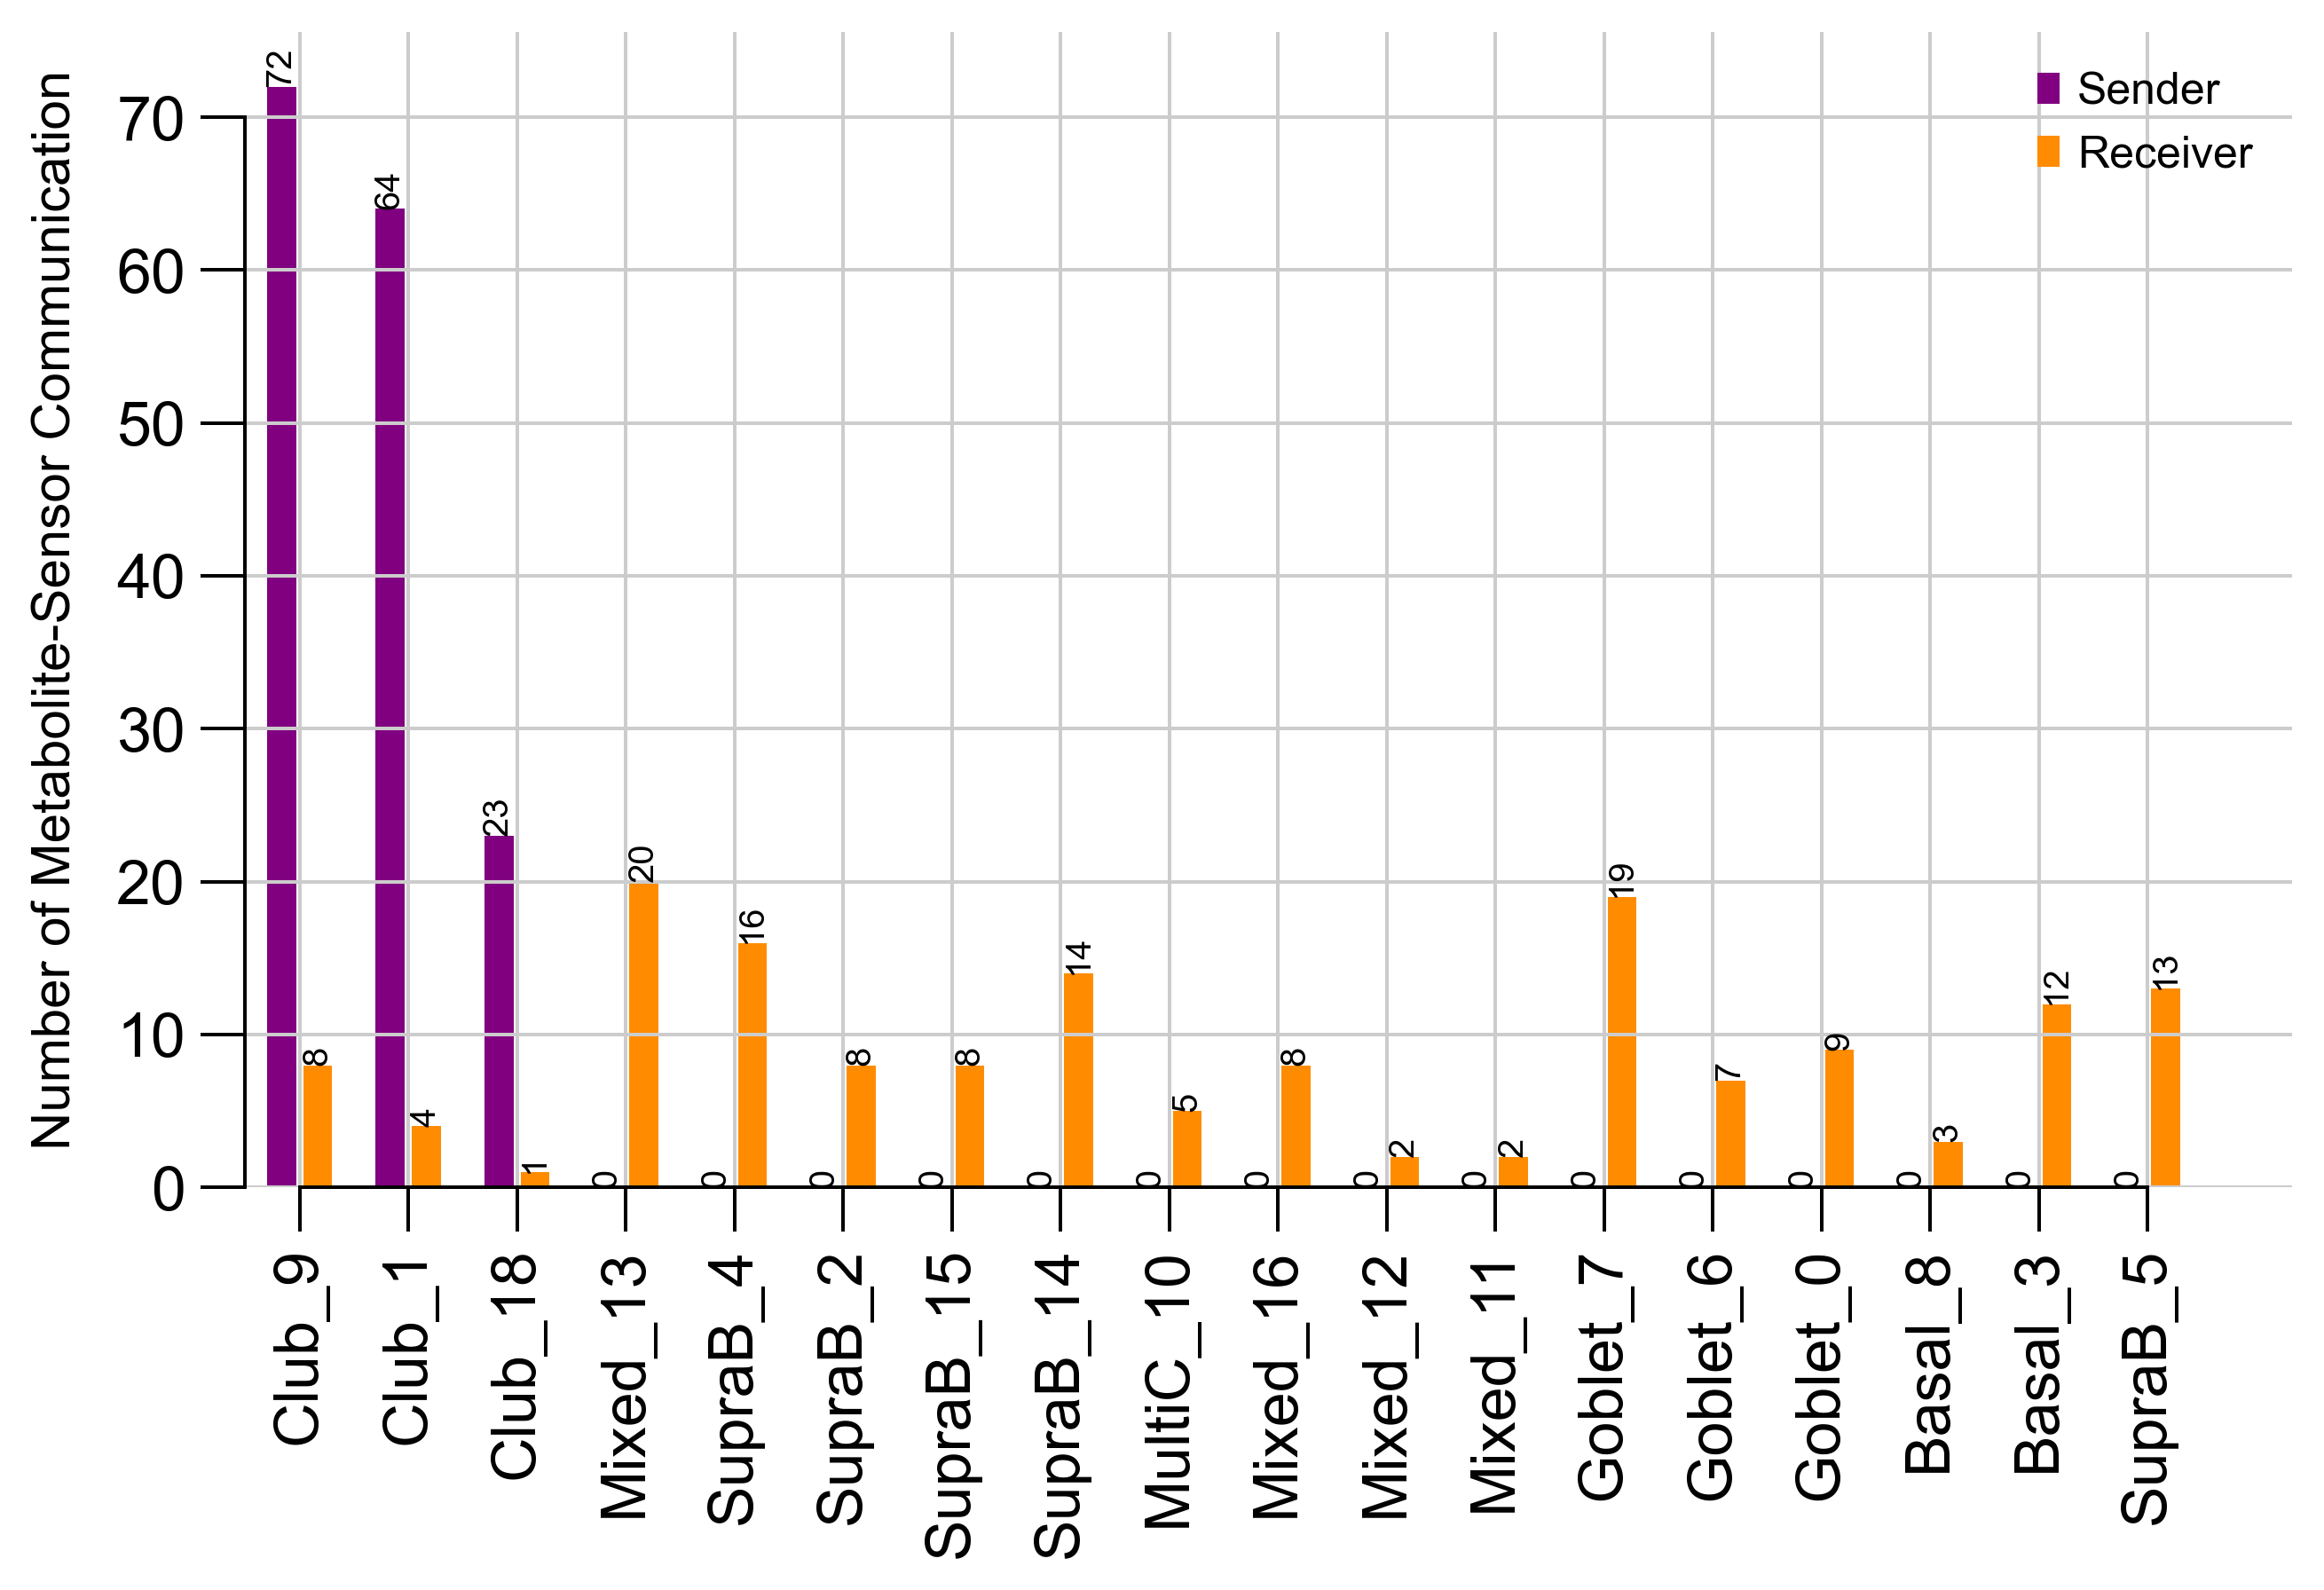

In [17]:
mebo_obj.eventnum_bar(
                    sender_focus = ['Club_1', 'Club_9', 'Club_18'],
                    metabolite_focus = [],
                    sensor_focus = [],
                    receiver_focus = [],
                    and_or = 'and',
                    pval_method = 'permutation_test_fdr',
                    pval_cutoff = 0.05,
                    comm_score_col = 'Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize = 'auto',
                    save = None,
                    show_plot = True,
                    show_num = True,
                    include = ['sender-receiver'],
                    group_by_cell = True,
                    colorcmap = 'tab20',
                    return_fig = False
                )

- Showing the communication between sender and receiver in a dot plot


[April 26, 2023 15:59:09]: plot dot plot to show communication in cell type level


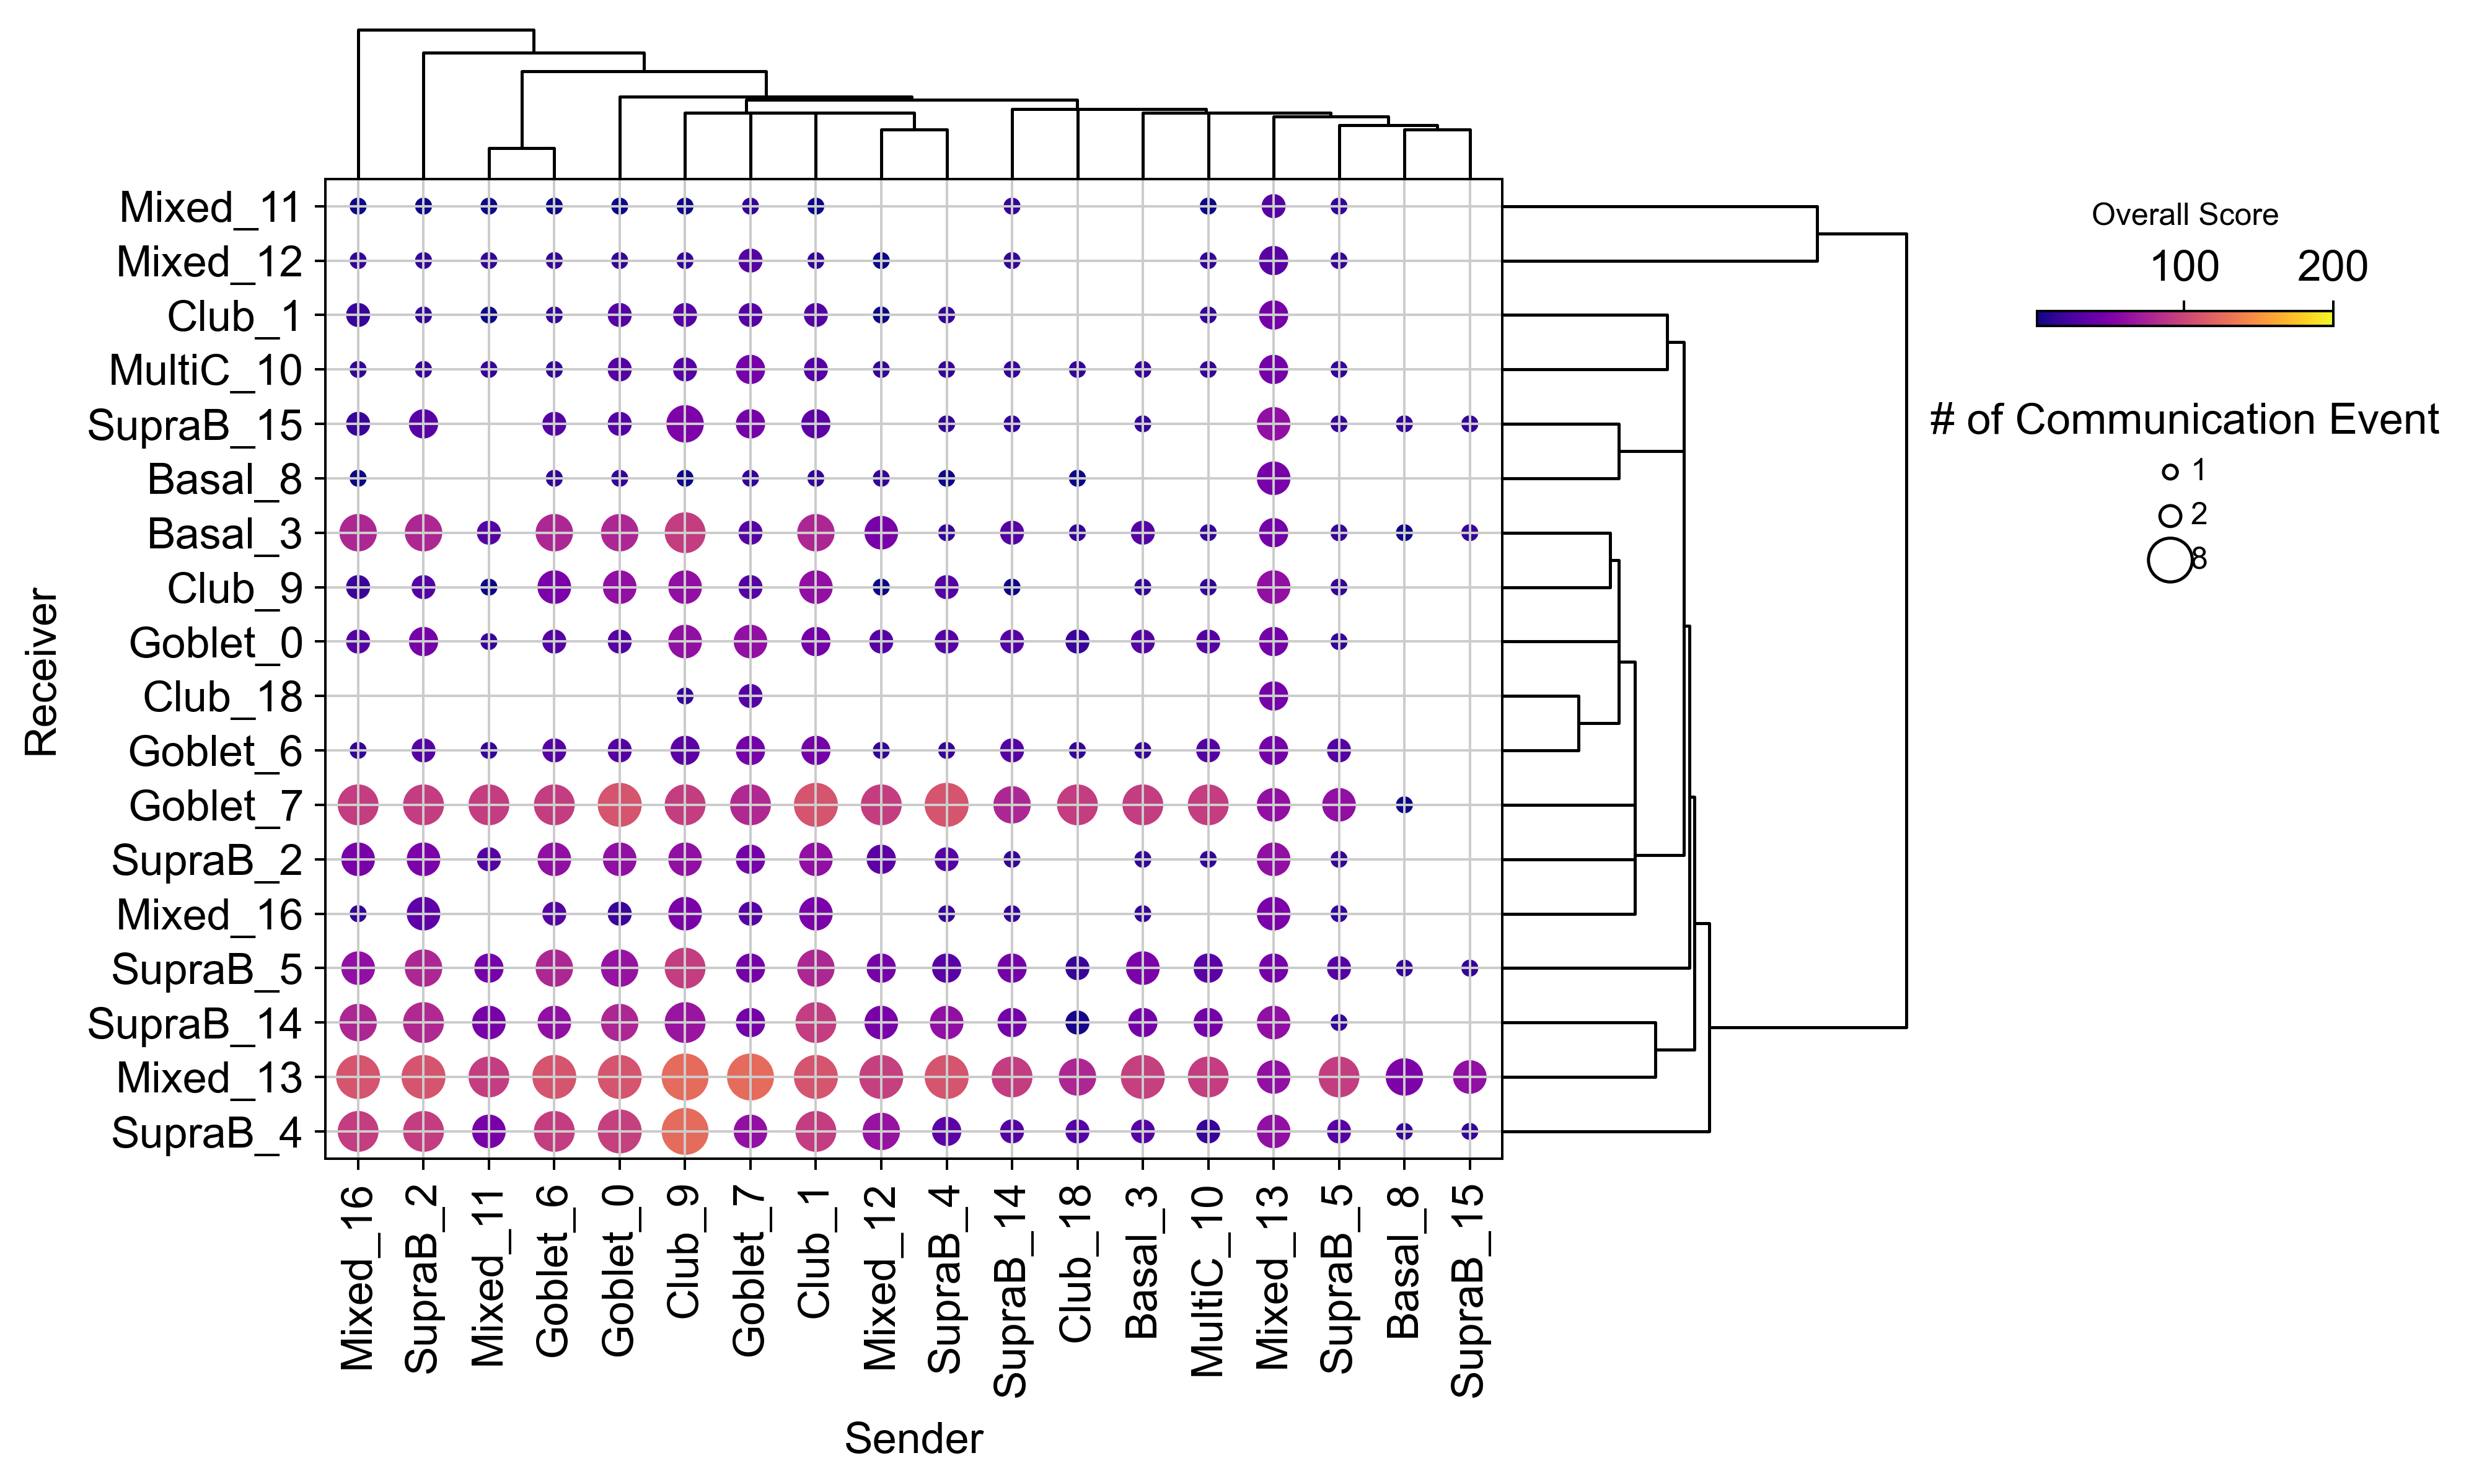

In [21]:
mebo_obj.count_dot_plot(
                        pval_method = 'permutation_test_fdr',
                        pval_cutoff = 0.05,
                        cmap = 'plasma',
                        figsize = 'auto',
                        save = None,
                        dot_size_norm = (20, 200),
                        dot_color_vmin = None,
                        dot_color_vmax = 200,
                        show_plot = True,
                        comm_score_col = 'Commu_Score',
                        comm_score_cutoff = 0,
                        return_fig = False
                    )

- Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

[April 26, 2023 15:54:35]: plot heatmap for significant result


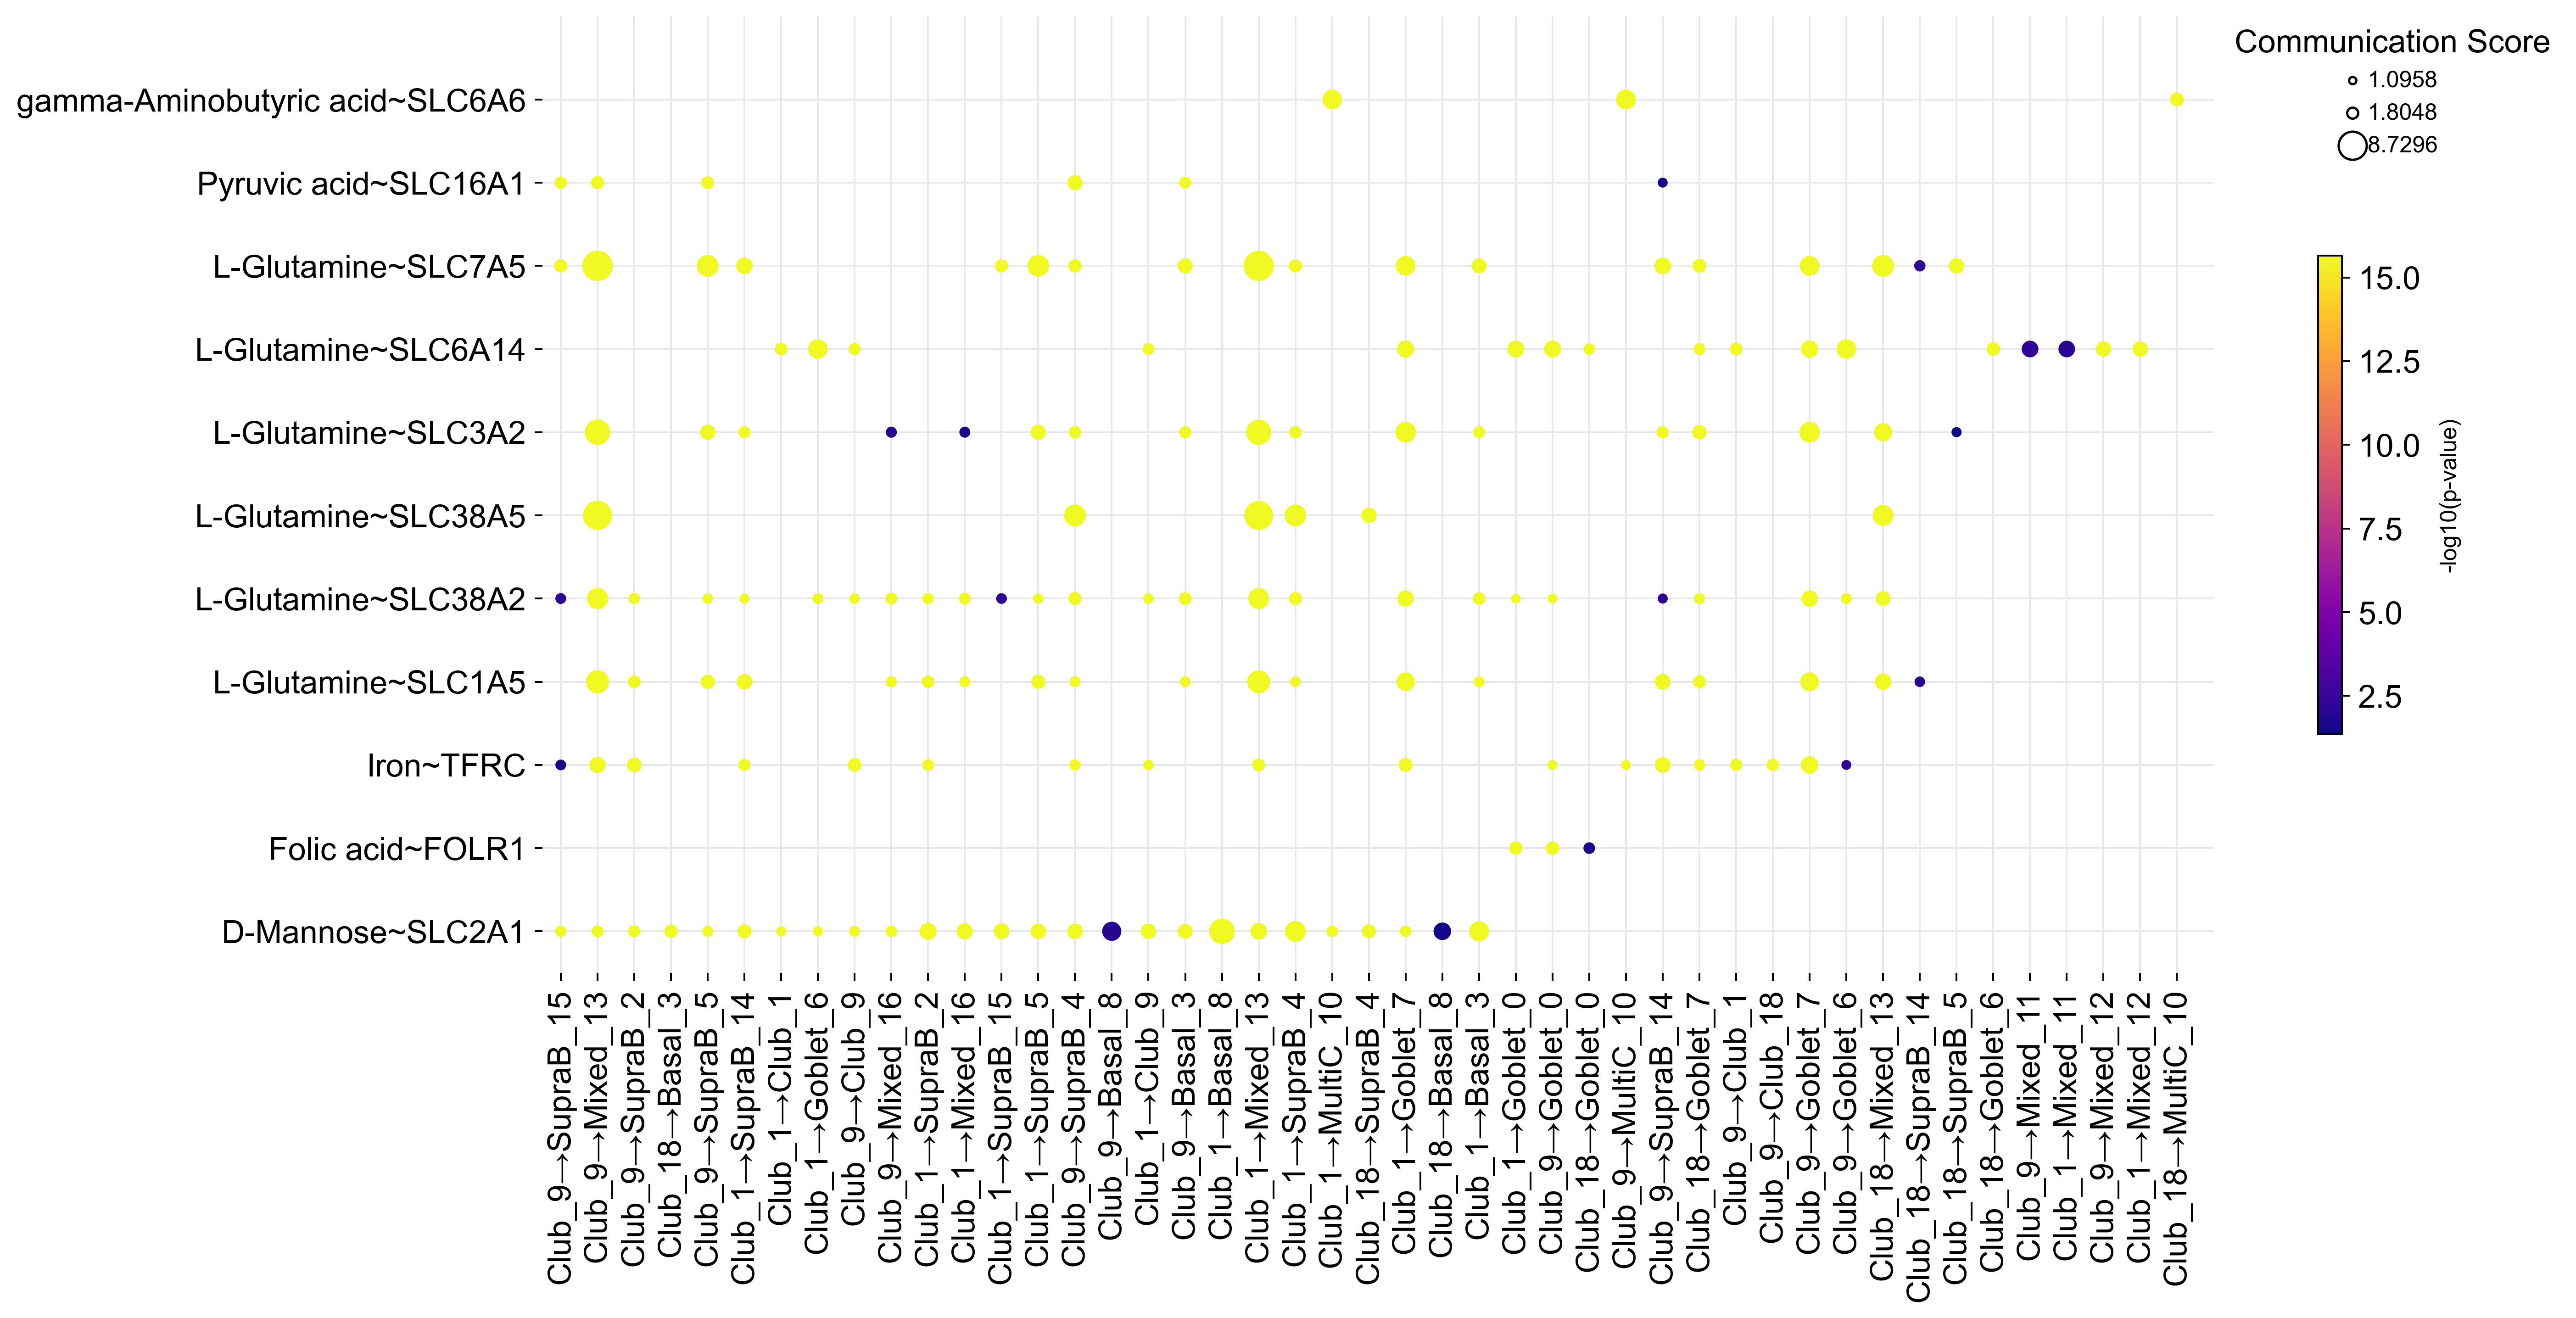

In [11]:
mebo_obj.commu_dotmap(
                sender_focus = ['Club_1', 'Club_9', 'Club_18'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )


- Visualization of the communication flow from sender metabolite to sensor in receiver

[April 26, 2023 15:55:07]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


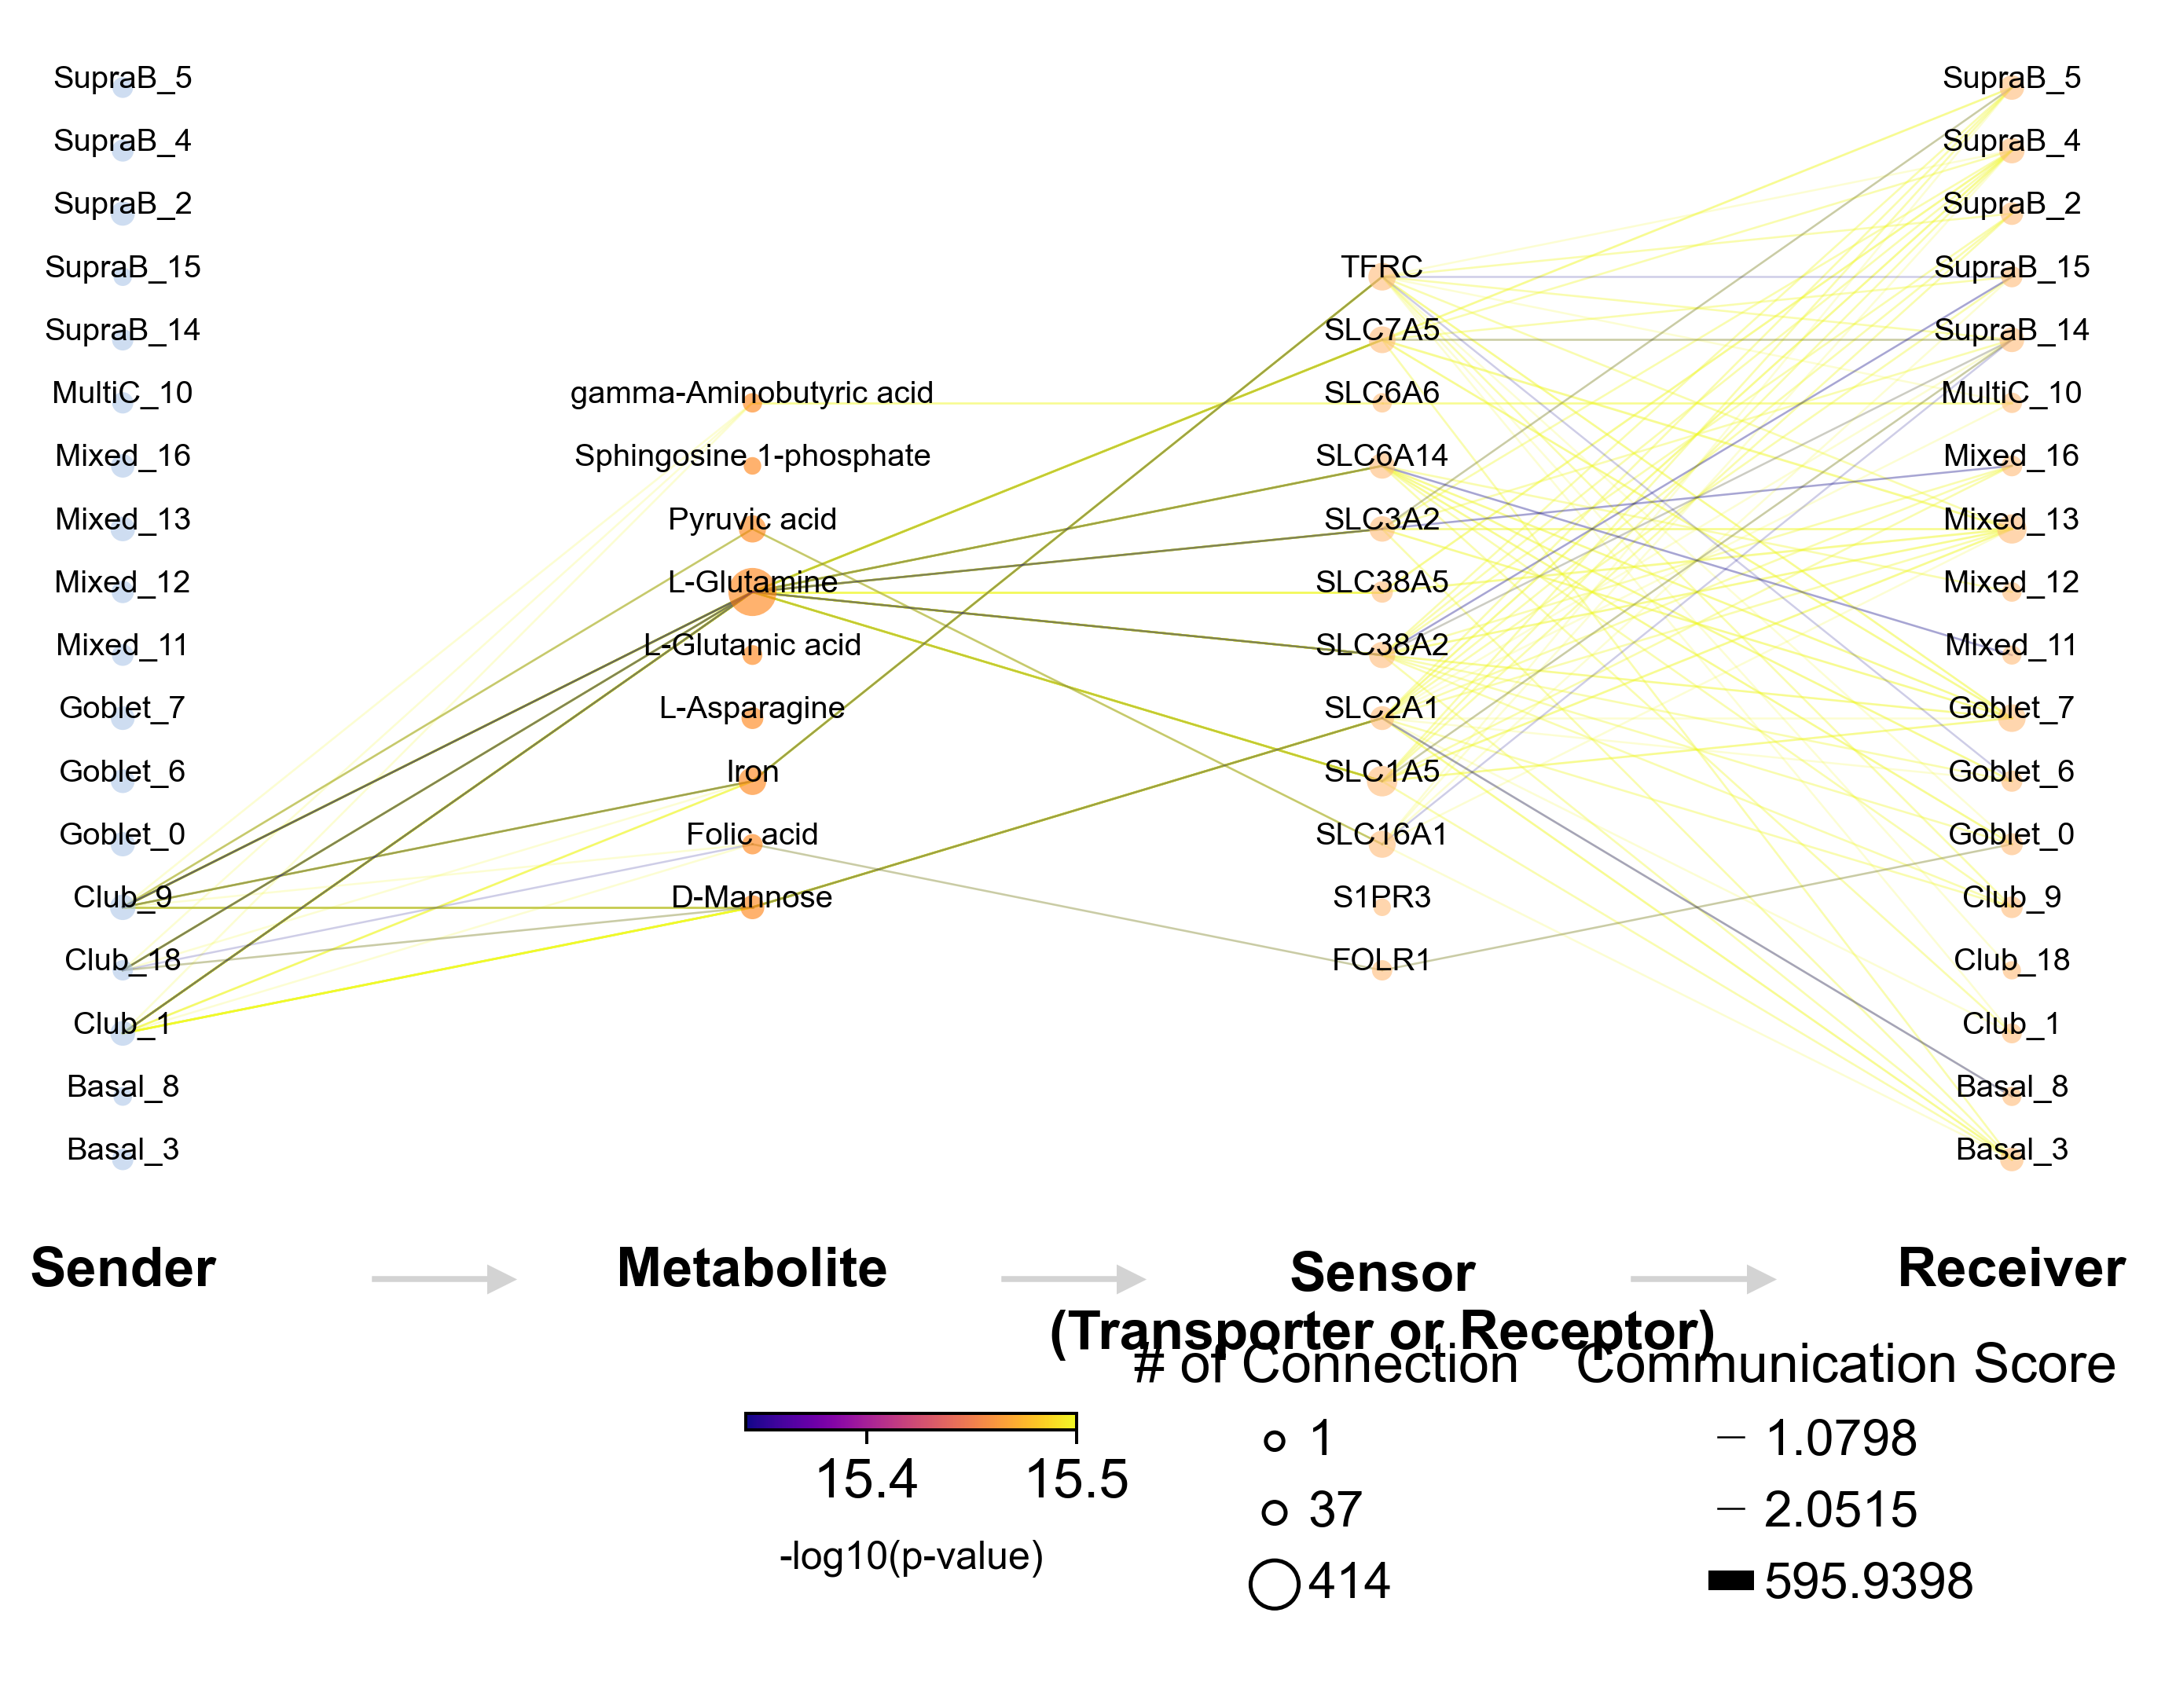

In [13]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = ['Club_1', 'Club_9', 'Club_18'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'plasma',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[April 26, 2023 15:55:35]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


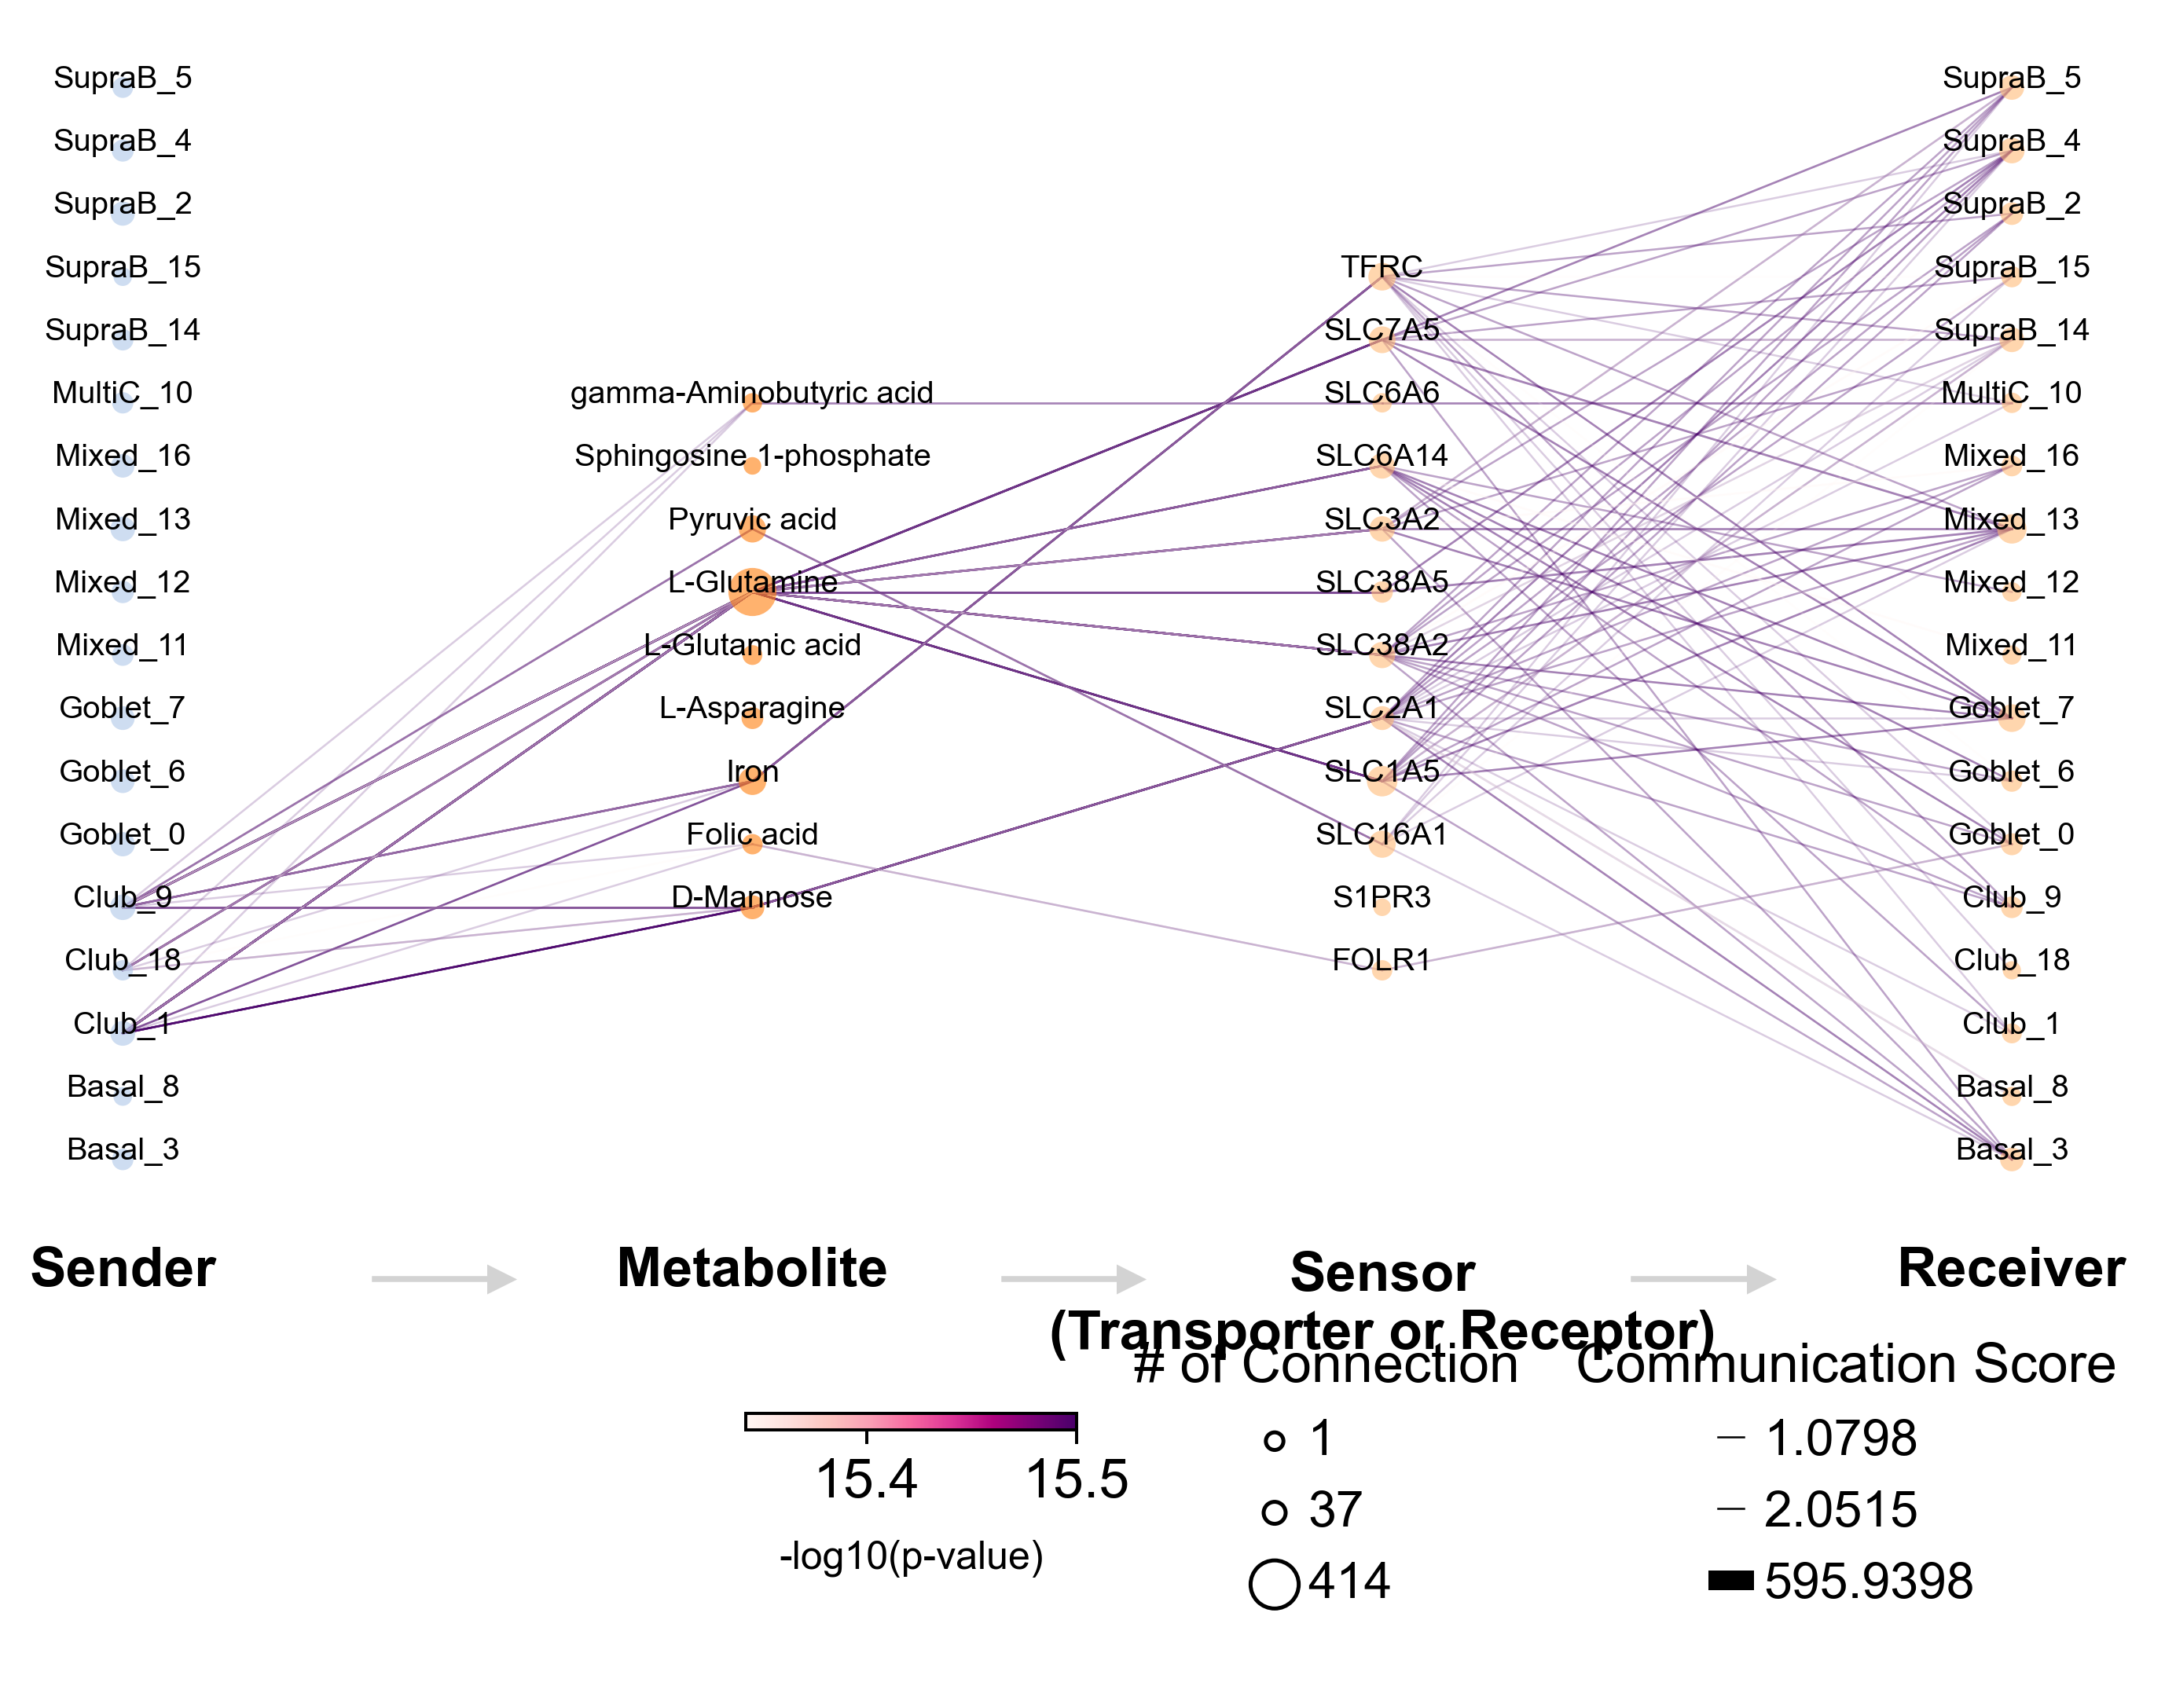

In [14]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = ['Club_1', 'Club_9', 'Club_18'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'RdPu',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

- Visualization of the metabolite level or sensor expression in cell groups

[April 26, 2023 15:55:49]: Warnings: no sensors to plot
[April 26, 2023 15:55:49]: Find metabolites ['L-Asparagine', 'D-Mannose', 'L-Glutamic acid', 'Iron', 'Folic acid'] to plot violin


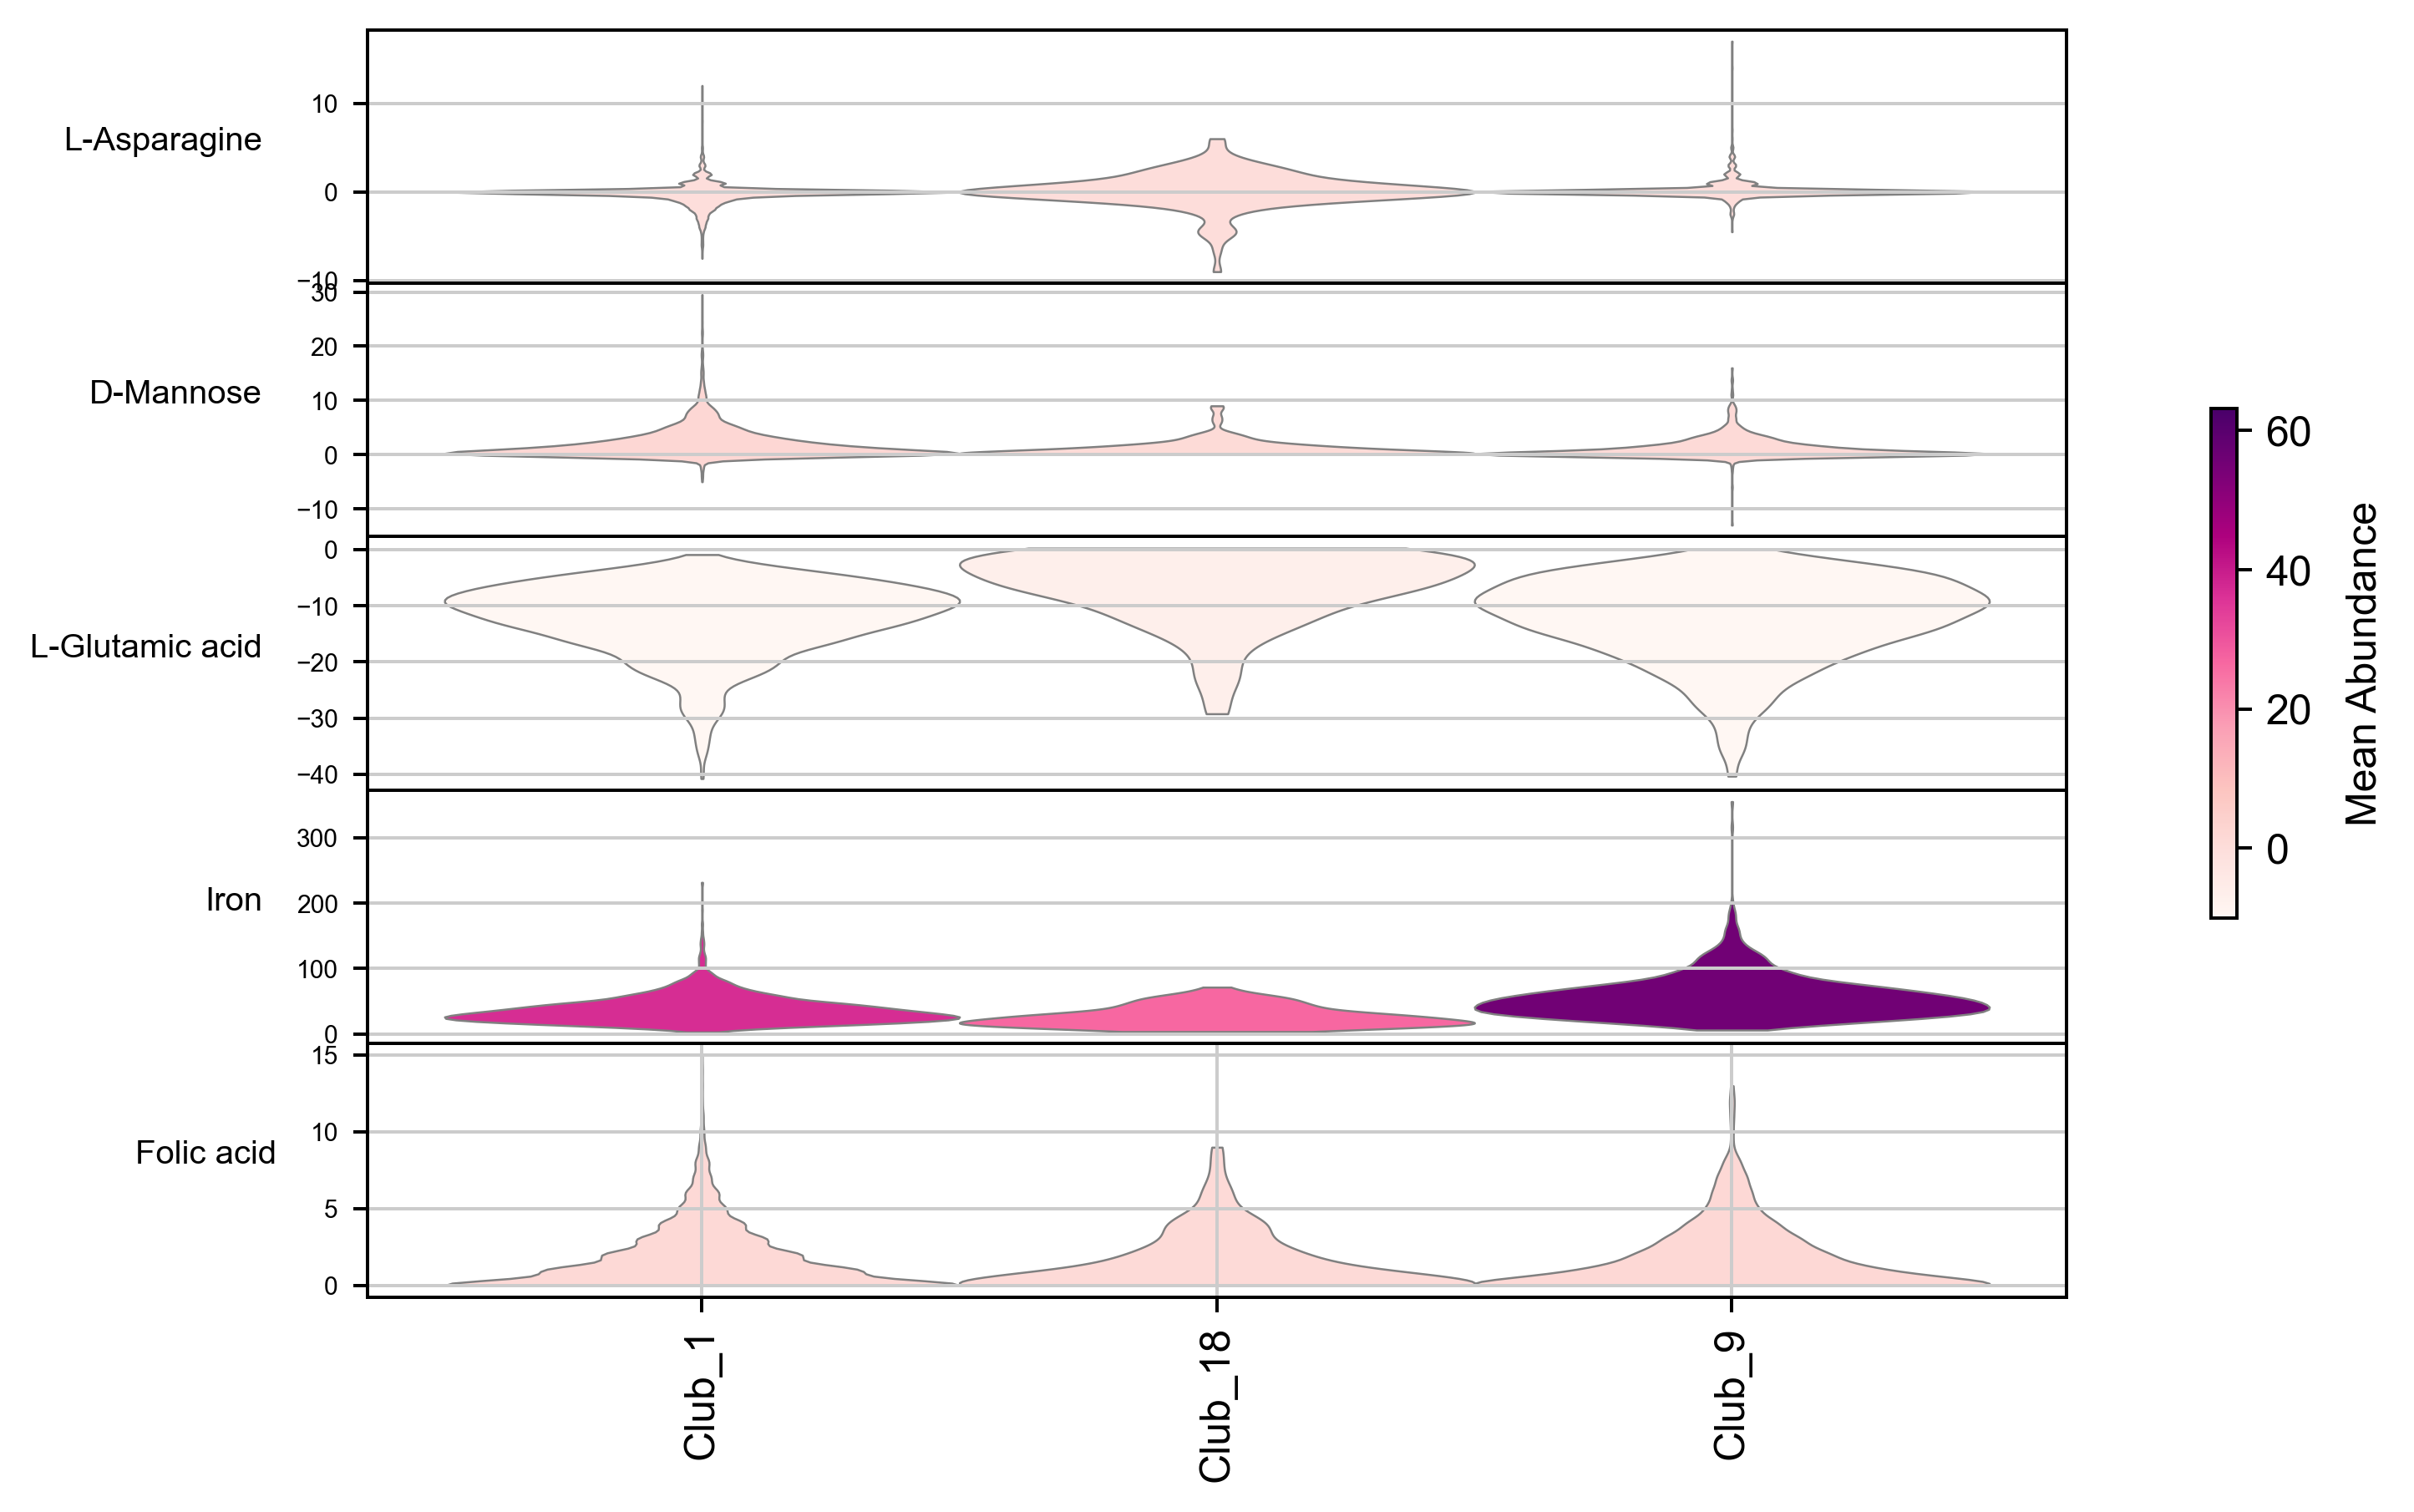

In [15]:
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:5], ## only top 5 as example
                    cell_focus = ['Club_1', 'Club_9', 'Club_18'],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )

[April 26, 2023 15:55:56]: Find genes Index(['FOLR1', 'S1PR3', 'SLC16A1', 'SLC1A5', 'SLC2A1'], dtype='object') to plot violin


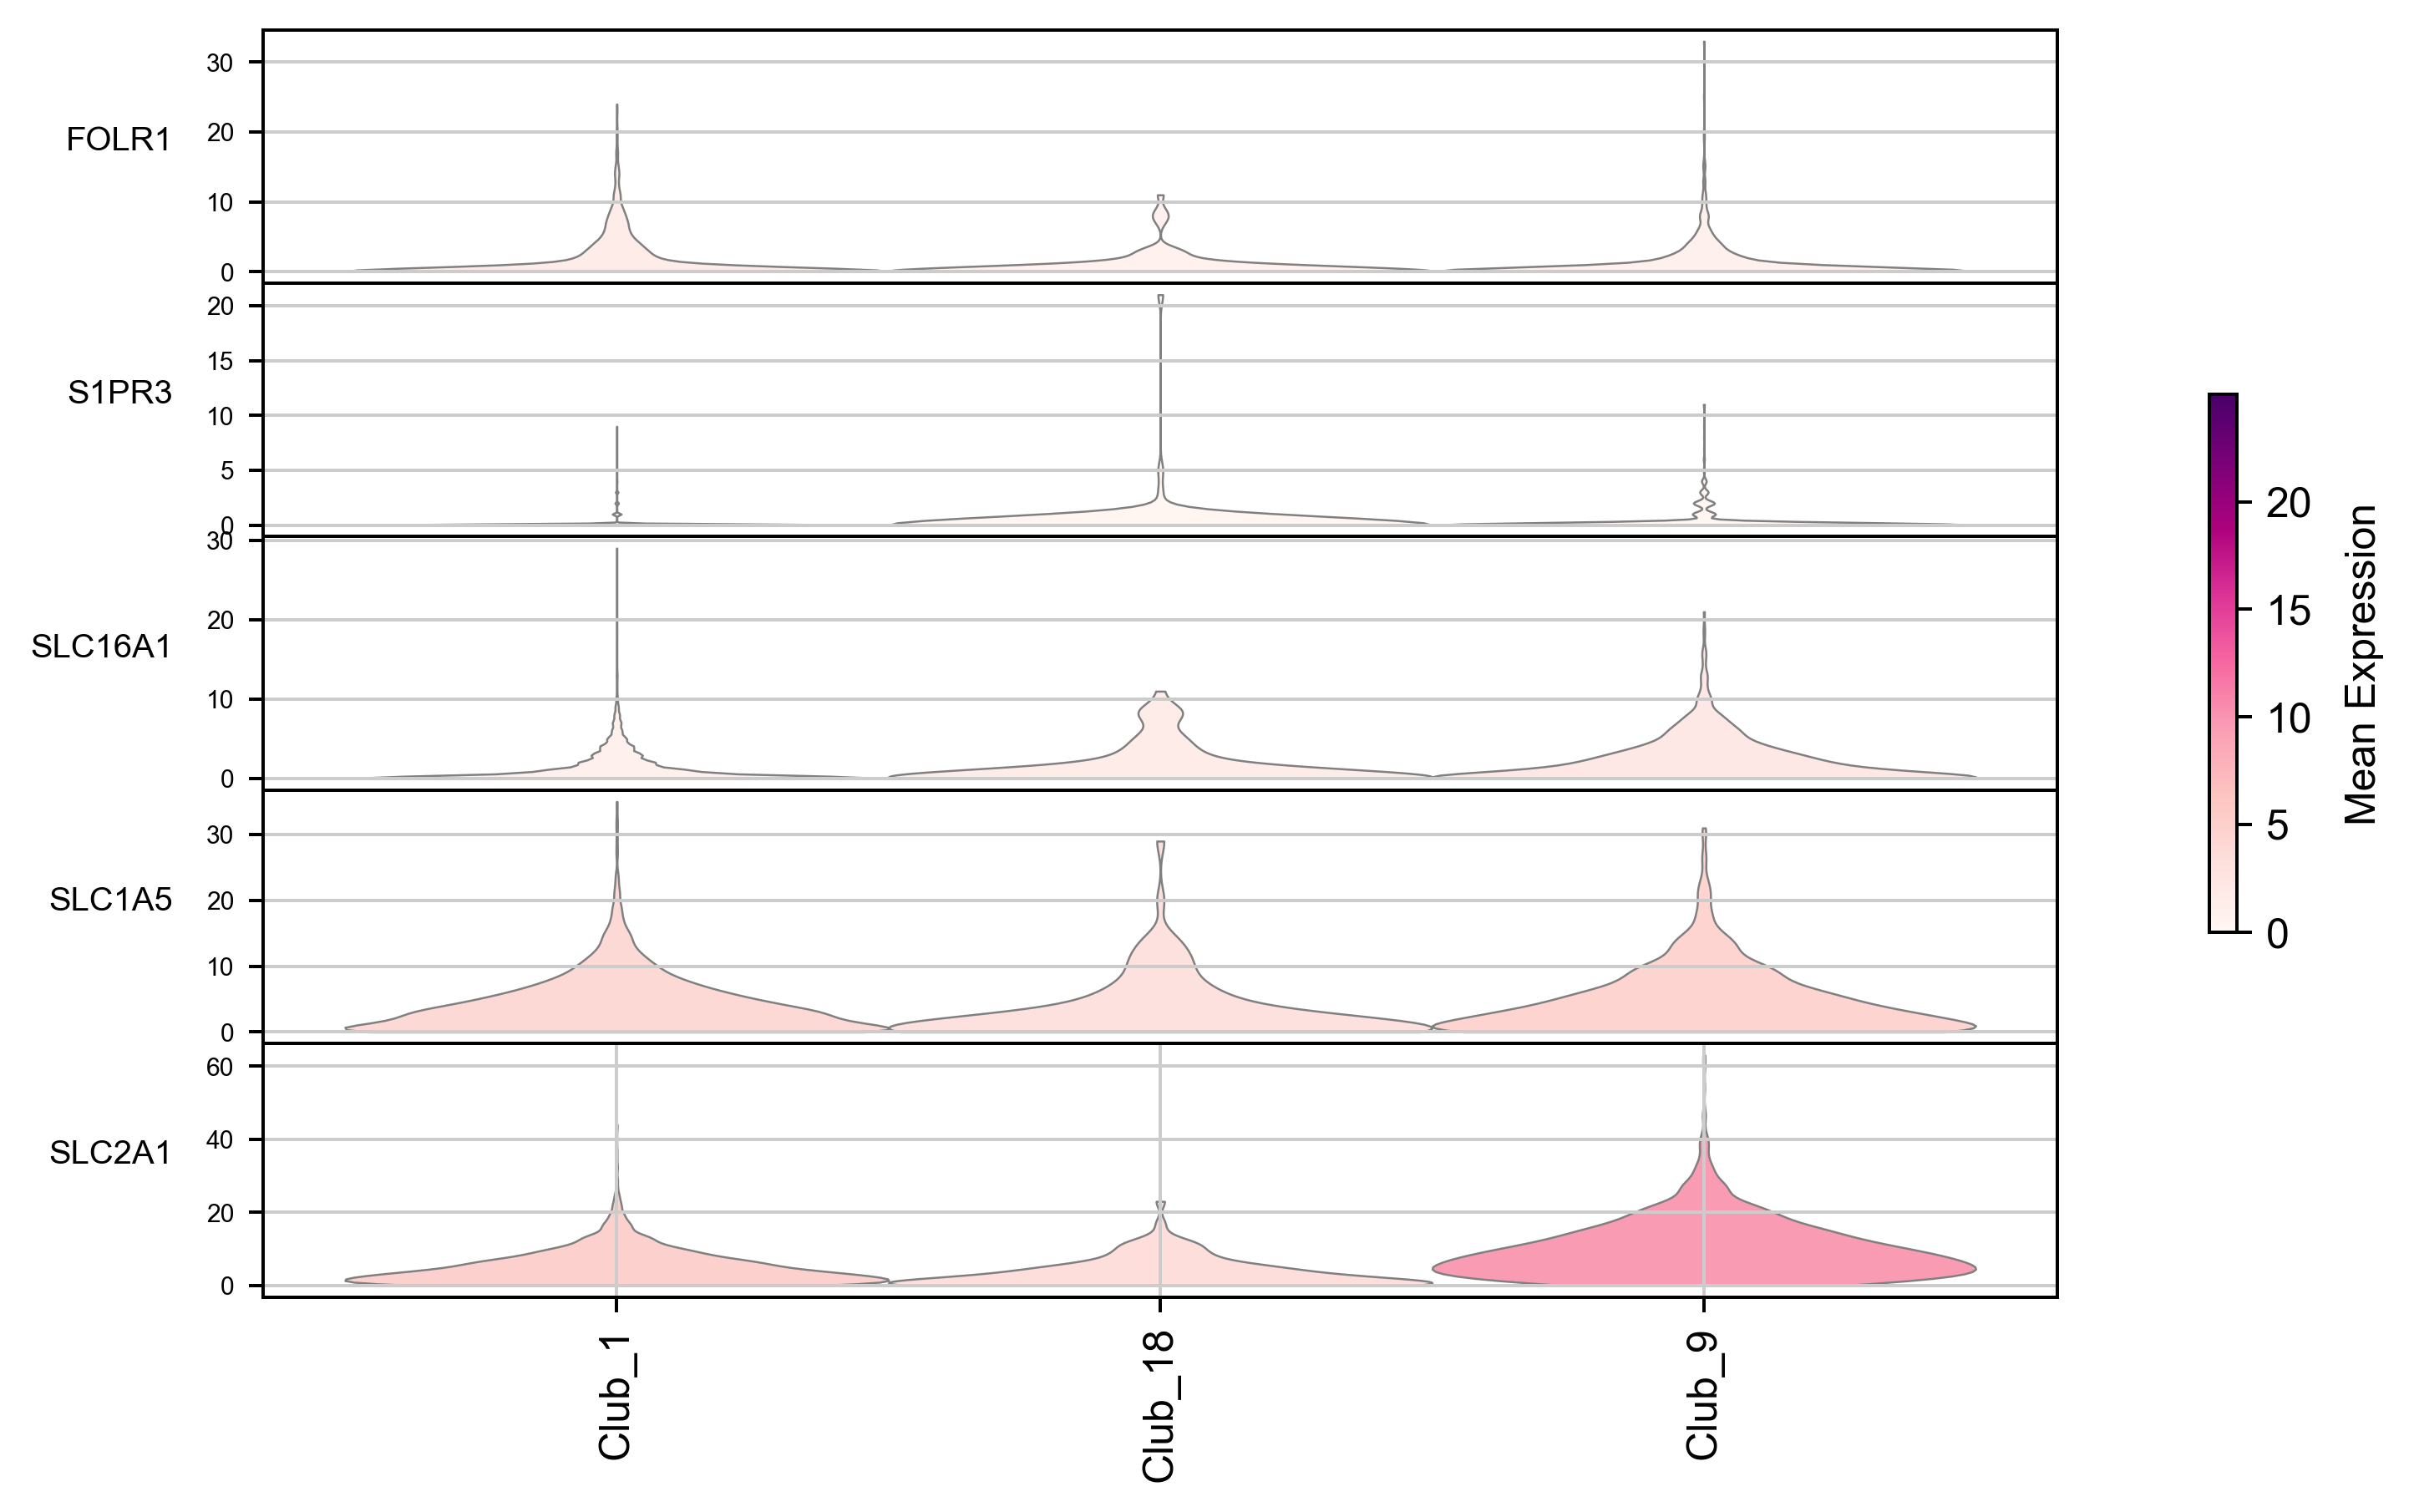

[April 26, 2023 15:55:59]: Warnings: no metabolites to plot


In [16]:
good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_sensor[:5],## only top 5 as example
                    cell_focus = ['Club_1', 'Club_9', 'Club_18'],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )